In [2]:
import keras
from keras.layers import SimpleRNN as RNN
import os
import fnmatch
from scipy.io import wavfile
import scipy
import sklearn.preprocessing as preprocessing
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import numpy as np
import scipy.fftpack as fft
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


['./cleanCut.wav', './distCut.wav']


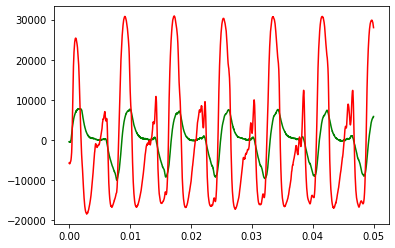

In [95]:
def recursive_files():
    matches = []
    for root, dirnames, filenames in os.walk('./'):
        for filename in fnmatch.filter(filenames, '*.wav'):
            matches.append(os.path.join(root, filename))
    return matches
    # wavfile.read('')

all_waves = list()

files = recursive_files()
files = sorted(files)
print(files)

for file in files:
    name = file.split('/')[-1]
    fs, signal =  wavfile.read(name)
    secs = signal.shape[0] / float(fs)
    Ts = 1.0/fs
    t = scipy.arange(0,secs,Ts)
    try: 
#         if("test" in name ):
#             train = list(signal)
#         if("predict" in name):
#             test = list(signal)
        insert = [name, list(signal)]
        all_waves.append(insert)
    except IndexError:
        print(IndexError)
        continue

hX = []
hy = []
X = []
y = []

for line in all_waves:
    if("clean" in line[0]):
        hX.append(line[0])
        for steps in range(len(line[1])):
            d = steps + 80
            X.append(line[1][steps:d])
    elif("dist" in line[0]):
        hy.append(line[0])
        y.append(line[1])
    else:
        y_test = line[1]


# for i in range(len(X)):
# X = preprocessing.maxabs_scale(X)
# for i in range(len(y)):
# y = preprocessing.maxabs_scale(y)

# w330test = preprocessing.maxabs_scale(test[0:-9])
# train = preprocessing.maxabs_scale(train)

# X_train = []
# for i in range(len(train)-9):
#     d= i + 10
#     X_train.append(train[i:d])


p1 = plt.plot(scipy.arange(0,(1/44100*2205),1/44100),all_waves[0][1][0:2205], "g")
p2 = plt.plot(scipy.arange(0,(1/44100*2205),1/44100),all_waves[1][1][:2205], "r")
plt.show()

In [98]:
X = np.array(X)
# X = np.reshape(X,(X.shape[0], 1, X.shape[1]))
# print(X.shape)

(80,)

In [59]:
Y = []
for i in all_waves[1][1][:X.shape[0]]:
    Y.append(i)

Y = np.array(Y)
Y.shape

(100000,)

In [60]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1, X.shape[2]), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 32)                3616      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 3,889
Trainable params: 3,889
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(X,Y, epochs=5, batch_size=16, verbose=2)

Epoch 1/5
 - 6s - loss: 55265858.7198
Epoch 2/5
 - 6s - loss: 44668253.3743
Epoch 3/5
 - 5s - loss: 40471595.2809
Epoch 4/5
 - 6s - loss: 38101271.5298
Epoch 5/5
 - 6s - loss: 36736803.1384


In [69]:
A = []
for steps in range(100000):
    d = steps + 80
    A.append(all_waves[0][1][(steps):(d)])

A = np.array(A)
A = np.reshape(A,(A.shape[0], 1, A.shape[1]))
predicted = model.predict(A)
predicted = predicted[:,0]

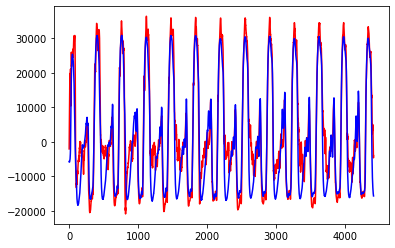

[-2068.5938   -291.59857  2631.2812  ... 27416.299   26614.492
 26193.559  ]


In [70]:
plt.plot(predicted[0:4410], c='r')
plt.plot(all_waves[1][1][0:4410], c='b')
plt.show()
print(predicted)

In [71]:
FFT = abs(scipy.fft(predicted[0:44100]))
FFT = preprocessing.maxabs_scale(FFT)
FFT_side = FFT[:1000]
freqs = fft.fftfreq(predicted[0:44100].size, 1/44100)
fft_freqs = np.array(freqs)
freqs_side = freqs[:1000]
fft_freqs_side = np.array(freqs_side)
FFT1 = abs(scipy.fft(Y[0:44100]))
FFT1 = preprocessing.maxabs_scale(FFT1)
FFT_side1 = FFT1[:1000]
freqs1 = fft.fftfreq(Y[0:44100].size, 1/44100)
fft_freqs1 = np.array(freqs1)
freqs_side1 = freqs1[:1000]
fft_freqs_side1 = np.array(freqs_side1)

print(mean_squared_error(FFT1,FFT))

9.832905335576714e-06


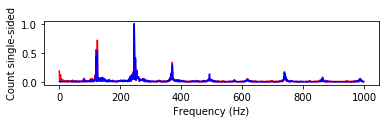

In [74]:
plt.subplot(313)
p3 = plt.plot(freqs_side, abs(FFT_side), "r")
p4 = plt.plot(freqs_side1, abs(FFT_side1), "b")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Count single-sided')
plt.show()

In [24]:
print(predicted)
print(Y)

wavfile.write("./result.wav",44100,predicted)

[-12889.511  -12887.94   -12679.153  ...   4022.0908   4634.973
   5272.5654]
[-12405 -12440 -12394 ...   2634   2256   1783]
